In [1]:
import numpy as np
import numpy.random as nrm
import random as rm
from matplotlib.pyplot import *
import time
import itertools
from scipy.linalg import expm
from numpy import sqrt,pi,e,cos,sin,tan
from scipy.optimize import minimize

File input

In [25]:
clauses = []
f=open('/home/aniruddha/Documents/Projects/QuICS/AdOpt/scripts/VQE/3sat_n8_m50.dimacs','r') # Input file, cnf format
while True:
    line = f.readline()
    if not line: break
    spline = line.split()
    if spline[0]=='c':
        continue
    elif spline[0]=='p':
        N = int(spline[2])
        M = int(spline[3])
    else:
        for c in spline[:-1]:
            if abs(int(c))>N or int(c)==0:
                print("Error: variable indices must be non-zero and less than %d"%N)
                break;
        if spline[-1]!='0':
            print("Error: clause descriptions must have a terminal 0")
            break;
        clauses.append(map(int,spline[:-1]))
if len(clauses)!=M: print("Error: Need %d clauses"%M)
f.close()

Max sat function

In [26]:
sx = np.array([[0,1],[1,0]]) # A useful global definition
sz = np.array([[1,0],[0,-1]])
ii = np.identity(2)

def gate(n,i,X): # apply gate X on i-th qubit out of n qubits
    return np.kron(np.identity(2**(i-1)),np.kron(X,np.identity(2**(n-i))))

def energy(H,psi): return np.vdot(psi,np.dot(H,psi))

def clauseH(n,clause,signs):
    a = np.array(n*[ii])
    a[clause]=map(lambda x: 0.5*(ii+x*sz),signs) # creates an array with id on non-clause indices and a z-ish operator on
    return reduce(np.kron,a)                     # the clause indices

def maxksatH(n,clauses):
    H0 = -reduce(lambda a,b: a+b,map(lambda i: gate(n,i+1,sx),range(n)))  # the diffusion operator
    H1 = 0
    for i in range(len(clauses)):
        clause=map(lambda x: abs(x)-1,clauses[i]) # extract the zero-indexed clause number
        signs=map(np.sign,clauses[i])
        H1+= clauseH(n,clause,signs)
    return [H0,H1]

def maxksatEval(z,clauses):
    H = len(clauses)
    for i in range(len(clauses)):
        clause=map(abs,clauses[i])
        signs=map(np.sign,clauses[i])
        p = 1
        for j in range(len(clause)):
            p = p*(0.5*(1+signs[j])-signs[j]*z[clause[j]-1])
        H = H-p
    return H

def spikeH(n,alpha,beta):
    W  = 2*n**alpha
    H  = n**beta
    LOC= n/4
    H0 = n*np.identity(n+1)
    for i in range(n):
        H0[i,i+1] = -np.sqrt((i+1)*(n-i))
        H0[i+1,i] = -np.sqrt((i+1)*(n-i))
    H1 = np.diag(map(lambda x: x+spike(W,H,LOC,x),range(n+1))) #ramp with spike
    return [H0,H1]

def randmax2sat(N,M): # generate a random max-2-sat instance
    clauses=[]
    for i in range(M):
        [c1,c2]=rm.sample(range(1,N+1),2)
        clauses.append([(-1)**rm.randint(0,1)*c1,(-1)**rm.randint(0,1)*c2])
    return clauses

def state0(n):
    return 1./2.**(n/2.)*np.ones(2**n)

def QAOA(H,psi0,T): # Performs QAOA for T iterations non-greedily: minimizing energy over (2*pi)^(2p) dim. parameter landscape
    psi=psi0
    angles=[]
    E = [energy(H[1],psi0)]
    def Etrial(x): 
        psi=psi0
        for i in range(T):
            psi = np.dot(expm(-1.j*H[0]*x[2*i]), np.dot(expm(-1.j*H[1]*x[2*i+1]),psi))
        return energy(H[1],psi)-M
    x0 = [pi/4,pi/2]+2*(T-1)*[0]
    opt = minimize(Etrial, x0, method='nelder-mead', bounds=2*T*[(-pi/10.,2*pi)], options={'xtol': 1e-8, 'disp': False})
    return opt.x, opt.fun

def greedyQAOA(H,psi0,T): # Performs QAOA for T iterations greedily: minimizing energy at each step
    psi=psi0
    angles=[]
    E = [energy(H[1],psi0)]
    def Etrial(x): 
        psi = np.dot(expm(-1.j*H[0]*x[0]), np.dot(expm(-1.j*H[1]*x[1]),psi0))
        return energy(H[1],psi)-M
    x0 = [pi/4,pi/2]
    for i in range(T):
        opt = minimize(Etrial, x0, method='nelder-mead', bounds=2*[(-pi/10.,2*pi)], options={'xtol': 1e-8, 'disp': False})
        x0=opt.x
        psi0 = np.dot(expm(-1.j*H[0]*opt.x[0]), np.dot(expm(-1.j*H[1]*opt.x[1]),psi0))
    return opt.x, opt.fun

Exhaustive search to find maximum satisfiability (WARNING: SCALES EXPONENTIALLY IN # OF BITS)

Nbit = list(itertools.product([0,1],repeat=N))
minE = M
minz = []
for z in Nbit:
    zE = maxksat(z)
    if minE >= zE:
        minE = zE
        minz = z
print minz, minE  

In [163]:
c = [1,2]
sign = [0,1]
a = np.array([2,2,2,2])
a[c]=map(lambda x: (-1)**x, sign)
a

array([ 2,  1, -1,  2])

In [224]:
#N=3
#clauses = [[1,2],[-2,-1],[1,-2]]
#M=len(clauses)
print M-np.diag(maxksatH(N,clauses)[1])
H = maxksatH(N,clauses)
QAOA(H,state0(N),1)[1]

[ 43.  41.  45.  42.  46.  42.  44.  41.  43.  45.  47.  48.  44.  43.  44.
  44.  47.  45.  48.  46.  45.  42.  44.  43.  42.  40.  47.  45.  41.  37.
  44.  42.]
Optimization terminated successfully.
         Current function value: -46.076192
         Iterations: 71
         Function evaluations: 139


-46.076192303264506

In [217]:
rm.randint(0,1)
rm.sample(range(10),3)

[8, 7, 1]

In [275]:
# Now I will randomly generate max2sat instances for fixed variable # N and clause # M, and compute 
# the expected approximation ratio for for fixed QAOA depth p
N=4
M=10
p=4
trials=50
approx=[]
for i in range(trials):
    clauses = randmax2sat(N,M)
    H = maxksatH(N,clauses)
    Cmax=max(M-np.diag(maxksatH(N,clauses)[1]))
    C=-greedyQAOA(H,state0(N),p)[1]
    approx.append(C/Cmax)

In [276]:
np.mean(approx)

0.93599119078727777

In [28]:
psi=state0(N)
H = maxksatH(N,clauses)
T=3
x = [0.5]*6
for i in range(T):
    psi = np.dot(expm(-1.j*H[0]*x[2*i]), np.dot(expm(-1.j*H[1]*x[2*i+1]),psi))
print energy(H[1],psi)
np.diag(H[1])

(5.22003407194+1.11022302463e-16j)


array([  5.,   5.,   4.,   6.,   5.,   5.,   6.,   8.,   6.,   5.,   4.,
         5.,   6.,   5.,  10.,  11.,   4.,   4.,   3.,   5.,   4.,   4.,
         5.,   7.,   8.,   6.,   6.,   6.,   7.,   5.,  11.,  11.,   5.,
         7.,   2.,   5.,   6.,   8.,   5.,   8.,   9.,  10.,   5.,   7.,
         8.,   9.,  10.,  12.,   6.,   7.,   4.,   6.,   7.,   8.,   7.,
         9.,  14.,  13.,  11.,  11.,  12.,  11.,  15.,  15.,   8.,   8.,
         5.,   7.,   5.,   4.,   5.,   6.,  10.,   7.,   6.,   5.,   8.,
         4.,  11.,   9.,   7.,   8.,   4.,   7.,   4.,   4.,   4.,   6.,
        10.,   7.,   6.,   5.,   7.,   3.,  10.,   8.,   7.,   9.,   3.,
         6.,   5.,   6.,   4.,   6.,  13.,  12.,   8.,   8.,  10.,   8.,
        12.,  11.,   6.,   8.,   3.,   6.,   4.,   5.,   4.,   6.,  14.,
        12.,  10.,   9.,  10.,   7.,  13.,  11.,   5.,   4.,   6.,   6.,
         5.,   6.,   6.,   8.,   4.,   3.,   4.,   4.,   3.,   4.,   7.,
         9.,   3.,   3.,   3.,   4.,   3.,   5.,   

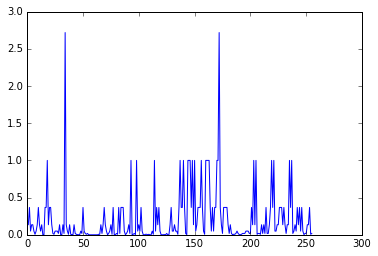

In [46]:
plot(np.exp(3-np.diag(H[1]))); show()

In [50]:
np.diag(H[1])[72]

10.0